# Initialization

In [23]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
import copy
import time

import preprocess
import pytorch_utils


dataset = preprocess.DatasetPreprocess("FinalData_Reshaped.csv", sequence_length=0, is_dataset_reshaped = True)

print("\nInitializing PyTorch...")
utils = pytorch_utils.Utils(dataset, use_cuda = True)

input_size = dataset.X_train_c.shape[1]
output_size = dataset.Y_train.shape[1]

categorical_variables: ['day_in_a_week', 'month', 'hour', '中山_status', '北投_status', '北門_status', '古亭_status', '士林_status', '大橋頭_status', '松山_status']
metro_flow index:  [0, 1, 2, 3, 4, 5, 6] 
categorical indices:  [14, 15, 16, 36, 37, 38, 39, 40, 41, 42] 
numerical indices:  [7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147]


7 unique day_in_a_week:	 [2.0, 3.0, 4.0, 5.0, 6.0, 0.0, 1.0]
12 unique month:	 [6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 1.0, 2.0, 3.0, 4.0, 5.0]
24 unique

C:\Users\yplab\anaconda3\envs\Vita_ML\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\yplab\anaconda3\envs\Vita_ML\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


# MLP Implementation

In [24]:
class MLP(nn.Module):
    def __init__(self, params):
        super(MLP, self).__init__()

        self.hidden_size = params["hidden_size"]
        self.p = params["dropout_rate"]

        self.fc1 = nn.Linear(input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, output_size)
        self.dropout = nn.Dropout(self.p)
    

    def forward(self, x):
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)

        return x
        
    def get_input_weights(self):
        return self.fc1.weight

gamma per epoch: 1.5848931924611136
residual: 7.105427357601002e-14

Initial: Train loss: 0.7486793

Step:1 	Train loss: 0.1985554 	LR: 1e-05
Step:2 	Train loss: 0.1545699 	LR: 1.5848931924611138e-05
Step:3 	Train loss: 0.1255232 	LR: 2.511886431509581e-05
Step:4 	Train loss: 0.0996321 	LR: 3.981071705534974e-05
Step:5 	Train loss: 0.0878555 	LR: 6.309573444801936e-05
Step:6 	Train loss: 0.0791063 	LR: 0.00010000000000000006
Step:7 	Train loss: 0.0793460 	LR: 0.00015848931924611145
Step:8 	Train loss: 0.0834034 	LR: 0.00025118864315095817
Step:9 	Train loss: 0.0857824 	LR: 0.0003981071705534975
Step:10 	Train loss: 0.2177255 	LR: 0.0006309573444801937

Time to train: 19.901s


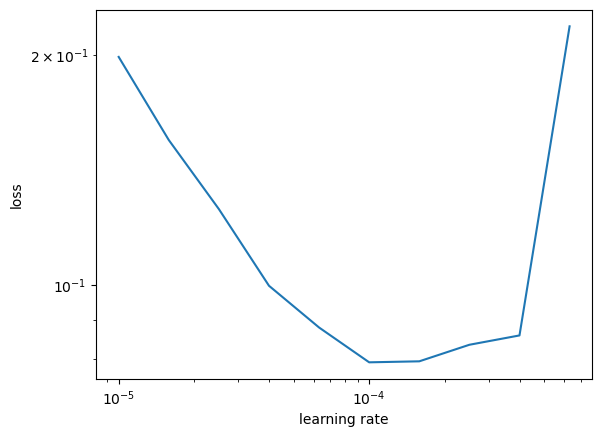

Best learning rate: 0.00010000000000000006
best_lr: 0.00010000000000000006
batch size of 8192 is larger than the dataset size!
max_batch_size: 4096


In [30]:
# Find the best initial learning rate
hidden_size = 10000

params = {'batch_size': 4, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': hidden_size, 'dropout_rate': 0, 'epochs': 10}
min_lr = 1e-5
max_lr = 1e-3

model, train_losses, learning_rates, best_lr_MLP = utils.Learning_Rate_Range_Test(MLP, min_lr, max_lr, params)
print("best_lr:", best_lr_MLP)

# Find the maximum batch size
max_batch_size_MLP = utils.get_max_batch_size(model)

# Grid Search - Dropout x Weight decay

In [4]:
# Parameters for grid search
epochs = [200]
batch_size = [4]
loss = ["MSE"]
lrs = [best_lr_MLP]
batch_growths = [False]
hidden_sizes = [hidden_size]
l1_reg = [0]

weight_decay = [0, 1e-4, 1e-3, 1e-2]
dropout_rates = [0, 0.1, 0.2, 0.5]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, hidden_sizes, dropout_rates, l1_reg]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "hidden_size", "dropout_rate", "l1_reg"]
params = utils.create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:\n")
for param in params:
    print(param)

# Grid search
best_val_params_MLP, grid_train_losses_MLP, grid_val_losses_MLP = utils.grid_search(MLP, params, max_batch_size_MLP)

print("Final training for the min val loss:")
best_model_MLP, best_val_loss_MLP, final_model_MLP, train_losses_MLP, val_losses_MLP = utils.train_model(MLP, best_val_params_MLP, max_batch_size_MLP, print_mode=True)

All grid searched values:

{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 0}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0.1, 'l1_reg': 0}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0.2, 'l1_reg': 0}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0.5, 'l1_reg': 0}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0.0001, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 0}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss'

# Evaluation - Dropout x Weight decay

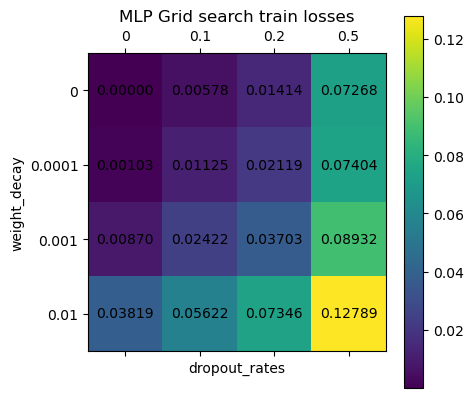

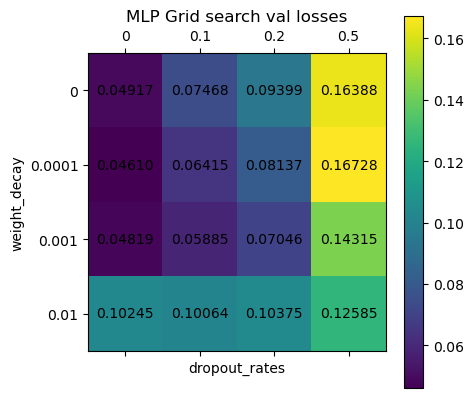

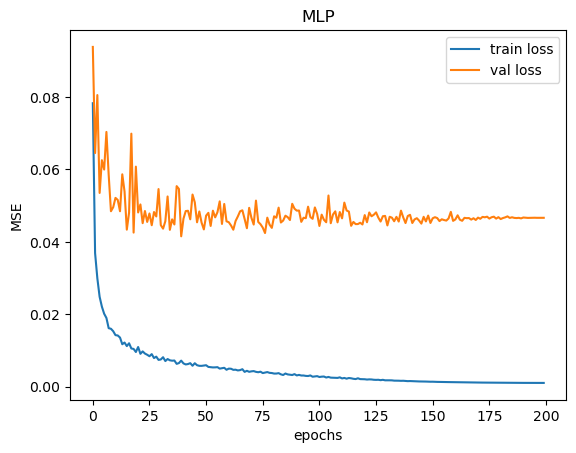

best val params:  {'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0.0001, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 0}
Train metrics:
	MSE: 0.007302266573506473
	Original scale MSE: 22605.849444546024

	RMSE: 0.08545330054191279
	Original scale RMSE: 150.3524174882001

	MAE: 0.05645889205408804
	Original scale MAE: 94.32437599059124

Validation metrics:
	MSE: 0.04153535257200448
	Original scale MSE: 106635.38490309089

	RMSE: 0.20380223887878288
	Original scale RMSE: 326.55073863504106

	MAE: 0.12268537039416709
	Original scale MAE: 201.99362007785385

Test metrics:
	MSE: 0.06303139773277613
	Original scale MSE: 145307.43675271666

	RMSE: 0.2510605459501276
	Original scale RMSE: 381.1921257748075

	MAE: 0.1616039909580294
	Original scale MAE: 255.9194803500625


In [5]:
# Show grid search progress
train_grid = np.zeros((len(weight_decay), len(dropout_rates)))
val_grid = np.zeros((len(weight_decay), len(dropout_rates)))

for i in range(len(grid_val_losses_MLP)):
    train_grid[i // len(dropout_rates), i % len(dropout_rates)] = grid_train_losses_MLP[i]
    val_grid  [i // len(dropout_rates), i % len(dropout_rates)] = grid_val_losses_MLP[i]

utils.plot_grid(grid_values=train_grid, title="MLP Grid search train losses", x_label="dropout_rates", y_label="weight_decay", x_values=dropout_rates, y_values=weight_decay)
utils.plot_grid(grid_values=val_grid  , title="MLP Grid search val losses"  , x_label="dropout_rates", y_label="weight_decay", x_values=dropout_rates, y_values=weight_decay)

# Plot the training progress
utils.plot_losses(train_losses_MLP, val_losses_MLP, "MLP")

# Show final model evaluation
print("best val params: ", best_val_params_MLP)
utils.evaluate_model(best_model_MLP, max_batch_size_MLP)

# Grid Search - L1 regularization x Batch growth

In [21]:
# Parameters for grid search
epochs = [200]
batch_size = [4]
loss = ["MSE"]
lrs = [best_lr_MLP]
weight_decay = [0]
hidden_sizes = [hidden_size]
dropout_rates = [0]

batch_growths = [False, True]
l1_reg = [1e-3, 5e-4, 2e-4, 1e-4, 5e-5, 2e-5, 1e-5]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, hidden_sizes, dropout_rates, l1_reg]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "hidden_size", "dropout_rate", "l1_reg"]
params = utils.create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:\n")
for param in params:
    print(param)

# Grid search
best_val_params_MLP, grid_train_losses_MLP, grid_val_losses_MLP = utils.grid_search(MLP, params, max_batch_size_MLP)

print("Final training for the min val loss:")
best_model_MLP, best_val_loss_MLP, final_model_MLP, train_losses_MLP, val_losses_MLP = utils.train_model(MLP, best_val_params_MLP, max_batch_size_MLP, print_mode=True)

All grid searched values:

{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 0.001}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 0.0005}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 0.0002}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 0.0001}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 5e-05}
{'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': F

# Evaluation - L1 regularization x Batch growth

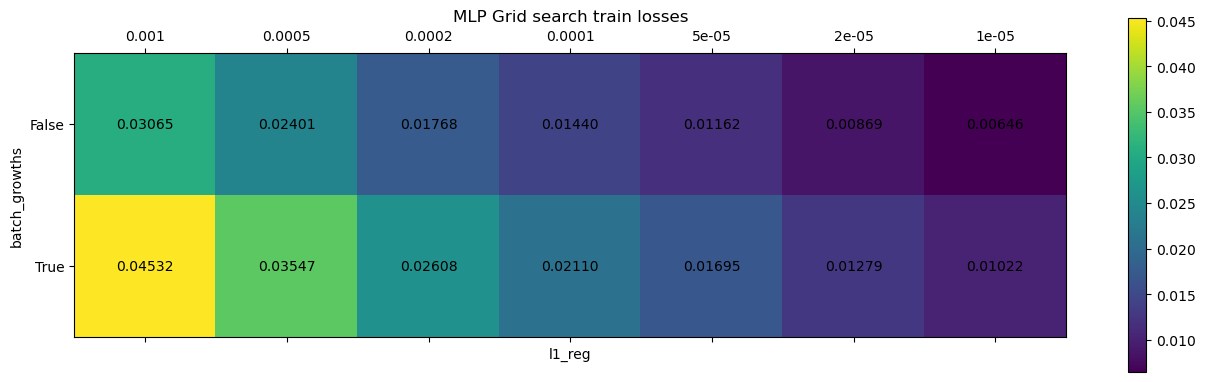

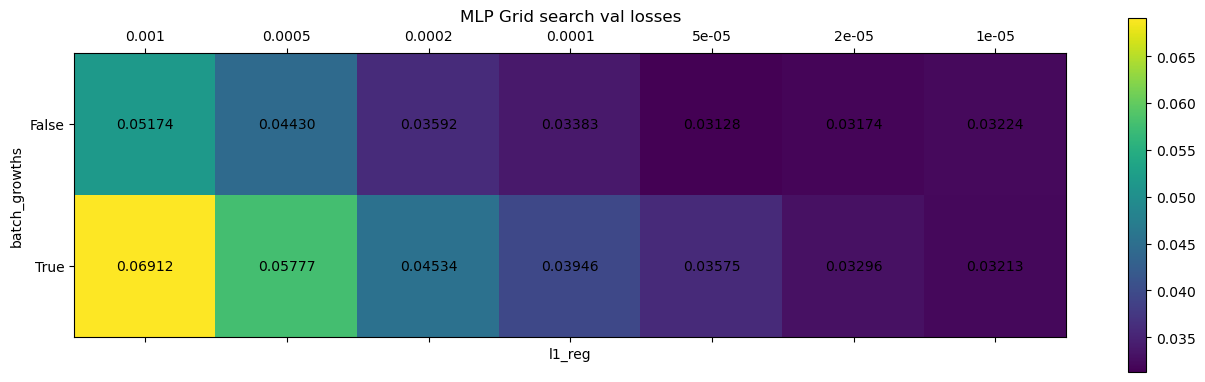

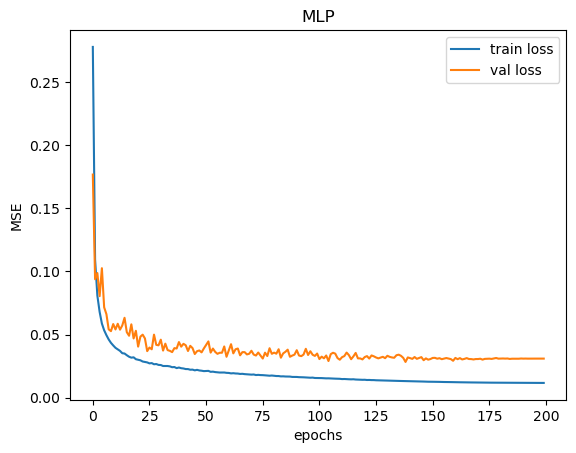

best val params:  {'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 5e-05}
Train metrics:
	MSE: 0.007705814847035748
	Original scale MSE: 21021.15748978569

	RMSE: 0.0877827707869588
	Original scale RMSE: 144.98674935933178

	MAE: 0.05701970648605495
	Original scale MAE: 93.96181522574223

Validation metrics:
	MSE: 0.028295017507759035
	Original scale MSE: 66732.78861733897

	RMSE: 0.16821122883969142
	Original scale RMSE: 258.3269026201858

	MAE: 0.0930669768299227
	Original scale MAE: 150.9535778377409

Test metrics:
	MSE: 0.03562161087283846
	Original scale MSE: 82450.78058547179

	RMSE: 0.18873688265105593
	Original scale RMSE: 287.1424395408519

	MAE: 0.11995905890359446
	Original scale MAE: 191.0360247869684


In [22]:
# Show grid search progress
train_grid = np.zeros((len(batch_growths), len(l1_reg)))
val_grid = np.zeros((len(batch_growths), len(l1_reg)))

for i in range(len(grid_val_losses_MLP)):
    train_grid[i // len(l1_reg), i % len(l1_reg)] = grid_train_losses_MLP[i]
    val_grid  [i // len(l1_reg), i % len(l1_reg)] = grid_val_losses_MLP[i]

utils.plot_grid(grid_values=train_grid, title="MLP Grid search train losses", x_label="l1_reg", y_label="batch_growths", x_values=l1_reg, y_values=batch_growths)
utils.plot_grid(grid_values=val_grid  , title="MLP Grid search val losses"  , x_label="l1_reg", y_label="batch_growths", x_values=l1_reg, y_values=batch_growths)

# Plot the training progress
utils.plot_losses(train_losses_MLP, val_losses_MLP, "MLP")

# Show final model evaluation
print("best val params: ", best_val_params_MLP)
utils.evaluate_model(best_model_MLP, max_batch_size_MLP)

In [33]:

best_val_params_MLP['l1_reg'] = 5e-5
best_model_MLP, best_val_loss_MLP, final_model_MLP, train_losses_MLP, val_losses_MLP = utils.train_model(MLP, best_val_params_MLP, max_batch_size_MLP, print_mode=True)


Initial: Test loss: 0.8384387

Epoch:1 	Train loss: 0.2801234 	Val loss: 0.1500370 	batch size: 4 	 LR: 9.999383162408327e-05
Epoch:2 	Train loss: 0.1067560 	Val loss: 0.1192790 	batch size: 4 	 LR: 9.997532801828637e-05
Epoch:3 	Train loss: 0.0815793 	Val loss: 0.0853581 	batch size: 4 	 LR: 9.994449374809871e-05
Epoch:4 	Train loss: 0.0696239 	Val loss: 0.0889473 	batch size: 4 	 LR: 9.990133642141363e-05
Epoch:5 	Train loss: 0.0608109 	Val loss: 0.0831023 	batch size: 4 	 LR: 9.984586668665647e-05
Epoch:6 	Train loss: 0.0529025 	Val loss: 0.0797434 	batch size: 4 	 LR: 9.977809823015455e-05
Epoch:7 	Train loss: 0.0507082 	Val loss: 0.0855514 	batch size: 4 	 LR: 9.969804777275969e-05
Epoch:8 	Train loss: 0.0471229 	Val loss: 0.0677622 	batch size: 4 	 LR: 9.960573506572444e-05
Epoch:9 	Train loss: 0.0443939 	Val loss: 0.0739051 	batch size: 4 	 LR: 9.950118288582828e-05
Epoch:10 	Train loss: 0.0423979 	Val loss: 0.0539175 	batch size: 4 	 LR: 9.938441702975784e-05
Epoch:11 	Train l

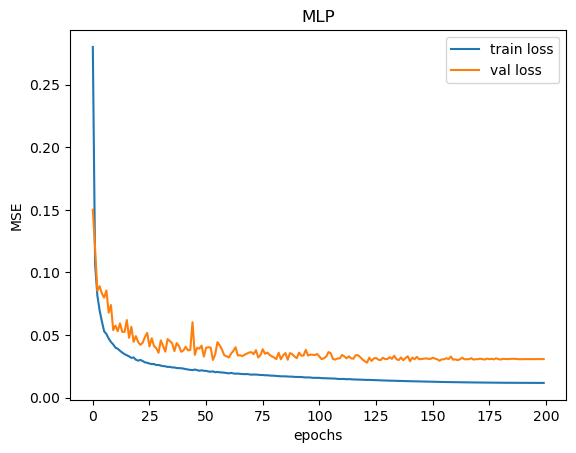

best val params:  {'epochs': 200, 'batch_size': 4, 'lr': 0.00010000000000000006, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size': 10000, 'dropout_rate': 0, 'l1_reg': 5e-05}
Train metrics:
	MSE: 0.007739219824161266
	Original scale MSE: 21820.88628169226

	RMSE: 0.0879728357174035
	Original scale RMSE: 147.71894354378608

	MAE: 0.05631191210196661
	Original scale MAE: 93.99834790334373

Validation metrics:
	MSE: 0.02783991716931918
	Original scale MSE: 65140.85898481241

	RMSE: 0.166852980702531
	Original scale RMSE: 255.22707337743856

	MAE: 0.09444275634687276
	Original scale MAE: 152.76106710312297

Test metrics:
	MSE: 0.03606867634391787
	Original scale MSE: 81088.46656632875

	RMSE: 0.18991755143724307
	Original scale RMSE: 284.7603669163403

	MAE: 0.12203896718114532
	Original scale MAE: 192.86699485008336


In [34]:
# Plot the training progress
utils.plot_losses(train_losses_MLP, val_losses_MLP, "MLP")

# Show final model evaluation
print("best val params: ", best_val_params_MLP)
utils.evaluate_model(best_model_MLP, max_batch_size_MLP)

In [35]:

#Save the final model
print("Saving model...")
path_to_save = "Models/MLP.model"
torch.save(best_model_MLP, path_to_save)

with open('Models/MLP_params.txt', 'w') as f:
    print(best_val_params_MLP, file=f)

Saving model...
